<a href="https://colab.research.google.com/github/ThanhNhanNg/Code-AI/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive #đăng nhập drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import os
import random
from keras.preprocessing.image import ImageDataGenerator

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices("GPU")[0], True)
# thư mục chứa 15 folder của các animals
path = "/content/drive/MyDrive/final"  
# Chia 20% số ảnh cho testing
testRatio = 0.2
 # Còn lại 80% cho train 
validationRatio = 0.2 

In [59]:
# Import Ảnh
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Tổng số Classes: ", len(myList))
noOfClasses = len(myList)
print(" Classes: ")
#đém số thư mục hiện có trong folder final
for x in range(0, len(myList)):
    PicList = os.listdir(path + "/" + str(count))
    for y in PicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        curImg = cv2.resize(curImg, (32,32))
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Tổng số Classes:  15
 Classes: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14  


In [60]:
# Chia dữ liệu 
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [61]:
# Kiểm tra số lượng ảnh có bằng với số LABLES cho mỗi dataset
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[0]), " TRAINING SET: Số lượng ảnh khác số lượng lables!"
assert (X_validation.shape[0] == y_validation.shape[0]), " VALIDATION SET: Số lượng ảnh khác số lượng lables!"
assert (X_test.shape[0] == y_test.shape[0]), " TESTING SET: Số lượng ảnh khác số lượng lables!"
assert (X_train.shape[1:] == (32,32,3)), " Kích thước ảnh Training SAI! "
assert (X_validation.shape[1:] == (32,32,3)), " Kích thước ảnh Validation SAI! "
assert (X_test.shape[1:] == (32,32,3)), " Kích thước ảnh Test SAI!"

Data Shapes
Train(1682, 32, 32, 3) (1682,)
Validation(421, 32, 32, 3) (421,)
Test(526, 32, 32, 3) (526,)


In [62]:
# READ CSV FILE
# File chứa tên và ID các classes
data = pd.read_csv('/content/drive/MyDrive/lables.csv') 
print("data shape ", data.shape, type(data))

data shape  (15, 2) <class 'pandas.core.frame.DataFrame'>


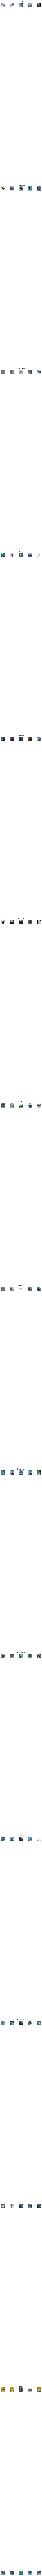

In [63]:
# Biểu diễn ngẫu nhiên một số ảnh mẫu
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))

[121, 126, 135, 175, 139, 153, 69, 88, 75, 99, 100, 126, 93, 94, 89]


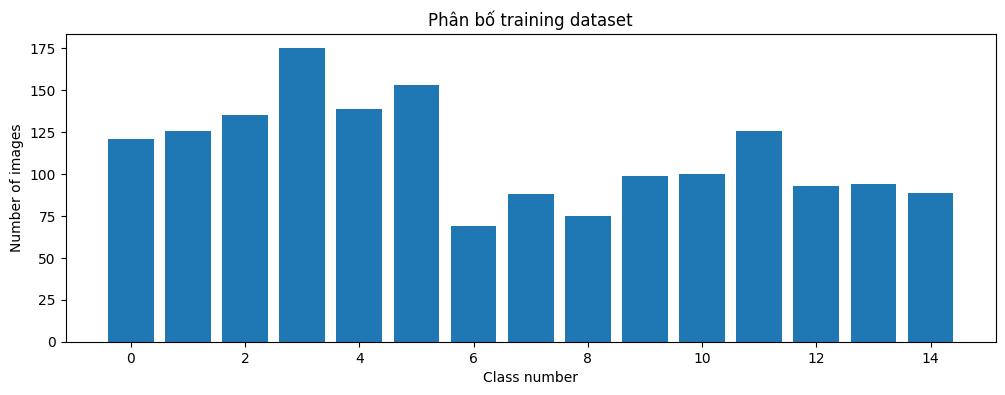

In [64]:
# PLOT biểu đồ cột về số lượng Samples cho mỗi loại
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Phân bố training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [65]:
# Xử lý ảnh
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)  # Cân bằng sáng cho ảnh
    img = img / 255  # Scale ảnh về giá trị 0-1
    return img

In [66]:
# Lấy ảnh đã xử lý và đưa vào lại các tập
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [67]:
# Reshape về (32,32,1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [68]:
# Rotate, shift-L/R, zoom images # nó sẽ quay hình qua lại cho mình để có thêm data
dataGen = ImageDataGenerator(width_shift_range=0.1,    # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

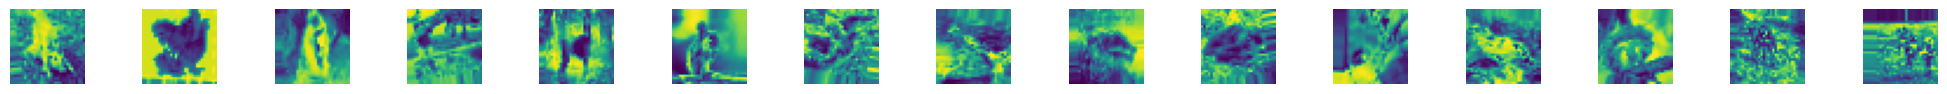

In [69]:
# Show ngẫu nhiên 15 ảnh sau xử lý
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape((32, 32, 3)[0], (32, 32, 3)[1]))
    axs[i].axis('off')
plt.show()

In [70]:
# Chuyển thành one-hot # chuyển từ numberical sang array để có thể train được
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [71]:
# CNN Model dựa theo LeNet
def myModel():
    num_Filters = 60
    size_of_Filter = (5, 5)  # KERNEL size.
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # Pooling size
    model = Sequential()
    model.add((Conv2D(num_Filters, size_of_Filter, input_shape=((32, 32, 3)[0], (32, 32, 3)[1], 1), activation='relu')))
    model.add((Conv2D(num_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add((Conv2D(num_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(num_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))  # => Giảm Overfitting

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))  # HIDDEN LAYER
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = myModel()

In [72]:
#Train model
print(model.summary())

history = model.fit(dataGen.flow(X_train, y_train, batch_size=50),
                    epochs=100, validation_data=(X_validation, y_validation), shuffle=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

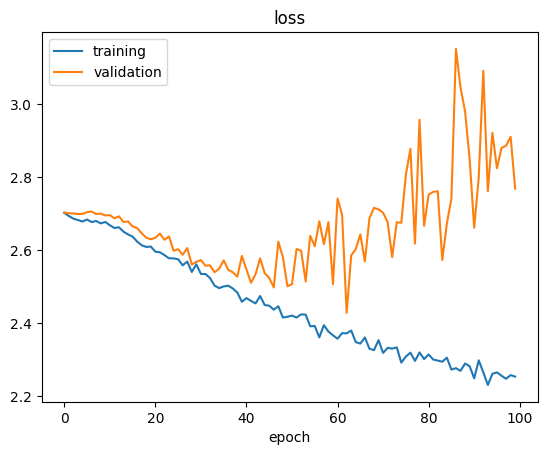

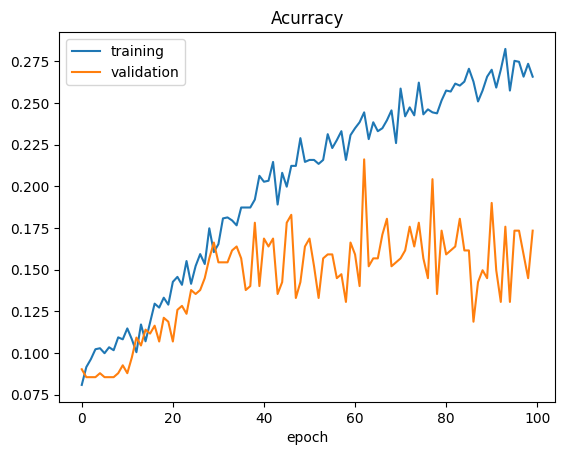

Test Score: 2.736272096633911
Test Accuracy: 0.17680607736110687


In [73]:
# PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

In [74]:
# Lưu model vào file .h5 để sử dụng cho real-time
model.save('/content/drive/MyDrive/data/model.h5')
cv2.waitKey(0)

-1

17/17 [==============================] - 0s 3ms/step
[[0.03 0.04 0.12 ... 0.03 0.07 0.08]
 [0.08 0.05 0.03 ... 0.02 0.06 0.02]
 [0.01 0.03 0.05 ... 0.   0.05 0.01]
 ...
 [0.02 0.05 0.11 ... 0.11 0.06 0.19]
 [0.04 0.12 0.31 ... 0.05 0.11 0.02]
 [0.   0.06 0.19 ... 0.02 0.16 0.2 ]]
[10  4  6  4 14 14  3  1 14  5  9 14 14 14 14 14  1 14 14 14 14  2 14  2
 14  2 14  4 14  3  3  3  3  9  0  0 14  2  5  2  1 14  2  5  3  5  2  2
  9 14  9  0  5 14  2 14  9 14 12  2  5  9 14 13 14  0  5  9 14 13  2  5
  6 14  3  2  5  1 14  2  3 14  2 14  9 14  3 14  3 14 14  2  3 14 14  9
 12  9  5  9  9  2 14  2  9 11  3 14 14  3  5 14  5 14 14 14 11  3 14  3
  2  5  3  0  2 13  1  5  9  3  5 14 13  9 14  9  5 14  9 14 14 14  2  1
  2  5 12  4  3 14 14 11 14  3 14  3 14 14  9  5 14 12  2  5  9  5 14  6
  2  3  3 14 14 14 14  9 14 12 14  9  9 14  3  5  9  3  0  5  3 14  3  2
  3  5  3 14  2  4 14  5  5 14  5 14  4 14  5  3 14 14  2  9 14  2 14  3
 14 14 12  2  9  2 14  3 14  5  3  3  5  2 12  4  9  5 14  1  

<Figure size 640x480 with 0 Axes>

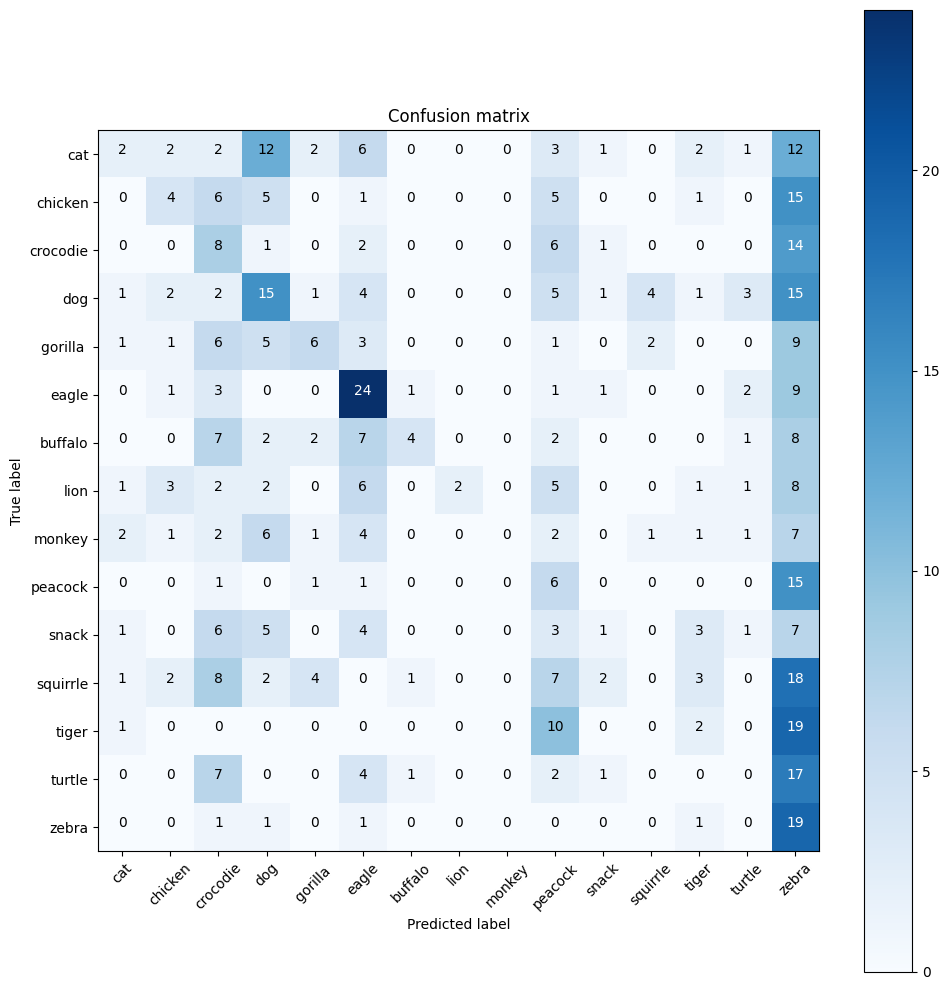

In [75]:
target_names = ['cat',
                'chicken',
                'crocodie',
                'dog',
                'gorilla ',
                'eagle',
                'buffalo',
                'lion',
                'monkey',
                'peacock',
                'snack',
                'squirrle',
                'tiger',
                'turtle',
                'zebra',]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)


cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=2)

plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
#plt.figure()
# Plot normalized confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
#                      title='Normalized confusion matrix')
#plt.figure()
plt.show()

In [76]:
import numpy as np
import tensorflow as tf
import cv2
from keras.models import load_model

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices("GPU")[0], True)
#THRESHOLD  là mức để máy xác định sự tự tin
threshold = 0.75 
font = cv2.FONT_HERSHEY_SIMPLEX

In [77]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [81]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import cv2
from keras.models import  load_model

# JavaScript to properly create our live video stream using our webcam as input
def preprocessing(img):# xử lý hình ảnh để đưa vô model dự đoán 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Bấm vào video để dừng</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Đang lấy hình ảnh...'
# initialze bounding box to empty
bbox = ''
count = 0 
#Load model nhận diện thú 
model_file_path ="/content/drive/MyDrive/data/model.h5"
model5 = load_model(model_file_path)
classes = ['cat','chicken','crocodie','dog','gorilla','eagle','buffalo','lion','monkey','peacock','snack','squirrle','tiger','turtle','zebra']

while True:
    # Đọc ảnh trả về từ JS
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # Convert JS response to OpenCV image
    frame = js_to_image(js_reply["img"])

    # Resize để đưa vào model
    frame_p = cv2.resize(frame, dsize =(32, 32))
    frame_p = preprocessing(frame_p)
    tensor = np.expand_dims(frame_p, axis =0)
    # Feed vào mạng
    pred = model5.predict(tensor)
    class_id = np.argmax(pred)
    class_name = classes[class_id]
    #Vẽ lên 1 ảnh để tạo nửa overplay
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
   
    bbox_array = cv2.putText(bbox_array, "{}".format(class_name),
                        (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 255,0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 84ms/step
